In [1]:
!pip install linearmodels pyblp -q

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import linearmodels as lm
from platform import python_version
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import quad
import pyblp
import scipy.optimize as optimize
import logging

print(python_version())

3.11.6


In [3]:
dist = np.random.default_rng(seed=228)

2 Generate Fake Data: Part (a) - Model Set-Up

In [4]:
T = 600
J = 4
n_obs = T * J
beta_1 = 1
beta_2 = beta_3 = 4
beta_2_sd = beta_3_sd = 1
alpha = -2
gamma_0 = 0.5
gamma_1 = 0.25

In [5]:
x = abs(dist.standard_normal(size=n_obs))
w = abs(dist.standard_normal(size=n_obs))
T_id = np.repeat(np.arange(T), J)
J_id = np.tile(np.arange(J), T)
resid_ds = dist.multivariate_normal([0, 0], [[1, 0.25], [0.25, 1]], n_obs)
resid_d = resid_ds[:, 0]
resid_s = resid_ds[:, 1]

In [6]:
data = pd.DataFrame(
{
"market_ids": T_id,
"firm_ids": J_id,
"x": x,
"w": w,
"resid_d": resid_d,
"resid_s": resid_s
}
)

In [7]:
data['satellite'] = np.where((data['firm_ids'] == 0) | (data['firm_ids'] == 1), 1, 0)
data['wired'] = np.where((data['firm_ids'] == 2) | (data['firm_ids'] == 3), 1, 0)

2 Generate Fake Data: Part (b) - Generate Prices

In [8]:
Integration = pyblp.Integration("product", 9)

In [9]:
X1_formulation = pyblp.Formulation("0 + x + satellite + wired + prices")
X2_formulation = pyblp.Formulation("0 + satellite + wired") 
X3_formulation = pyblp.Formulation("1 + w") 

In [10]:
price_compute = pyblp.Simulation(
product_formulations=(X1_formulation, X2_formulation, X3_formulation),
product_data=data,
beta=[beta_1, beta_2, beta_3, alpha],
sigma=[[1, 0], [0, 1]],
gamma=[gamma_0, gamma_1],
costs_type="log",
xi_variance=1,
omega_variance=1,
correlation=0.25,
seed=228,
integration=Integration,
)

Initializing the simulation ...
Initialized the simulation after 00:00:00.

Dimensions:
 T    N     F     I     K1    K2    K3 
---  ----  ---  -----  ----  ----  ----
600  2400   4   48600   4     2     2  

Formulations:
       Column Indices:             0          1        2      3   
-----------------------------  ---------  ---------  -----  ------
 X1: Linear Characteristics        x      satellite  wired  prices
X2: Nonlinear Characteristics  satellite    wired                 
X3: Log Cost Characteristics       1          w                   

Nonlinear Coefficient True Values:
 Sigma:      satellite        wired    
---------  -------------  -------------
satellite  +1.000000E+00               
  wired    +0.000000E+00  +1.000000E+00

Beta True Values:
      x          satellite        wired         prices    
-------------  -------------  -------------  -------------
+1.000000E+00  +4.000000E+00  +4.000000E+00  -2.000000E+00

Gamma True Values:
      1              w      
-

In [11]:
price_compute_r = price_compute.replace_endogenous()
product_data = pd.DataFrame(pyblp.data_to_dict(price_compute_r.product_data))

Replacing prices and shares ...
Replaced prices and shares after 00:00:03.

Simulation Results Summary:
Computation  Fixed Point  Fixed Point  Contraction  Profit Gradients  Profit Hessians  Profit Hessians
   Time       Failures    Iterations   Evaluations      Max Norm      Min Eigenvalue   Max Eigenvalue 
-----------  -----------  -----------  -----------  ----------------  ---------------  ---------------
 00:00:03         0          14051        14051      +4.547474E-13     -1.358473E+00    -3.273889E-41 


In [12]:
product_data

,prices,shares,market_ids,firm_ids,satellite,wired,x,w
0,2.431042,0.165149,0,0,1.0,0.0,0.584659,0.059686
1,2.208473,0.115427,0,1,1.0,0.0,0.615863,1.405901
2,3.282374,0.004873,0,2,0.0,1.0,0.008683,0.964780
3,1.817825,0.517959,0,3,0.0,1.0,0.219364,1.345774
4,1.810379,0.580827,1,0,1.0,0.0,1.497799,0.465470
...,...,...,...,...,...,...,...,...
2395,2.410689,0.474103,598,3,0.0,1.0,1.463330,2.092736
2396,2.031066,0.417114,599,0,1.0,0.0,1.273187,2.126454
2397,4.644768,0.000730,599,1,1.0,0.0,0.635075,0.463315
2398,2.007628,0.436439,599,2,0.0,1.0,1.577327,1.420527


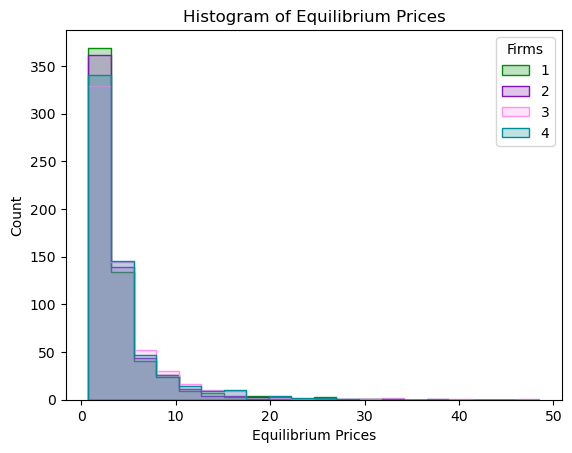

In [13]:
zhoskaya = {0: "#008c98",  
            1: "#ff91f0",  
            2: "#8014b6",  
            3: "#028f08"}  

sns.histplot(data=product_data, x='prices', hue='firm_ids', bins=20, element='step', palette=zhoskaya)
plt.title('Histogram of Equilibrium Prices')
plt.xlabel('Equilibrium Prices')
plt.legend(title='Firms', labels=["1", "2", "3", "4"])
plt.show()

In [14]:
product_data['prices'].describe()

count    2400.000000
mean        4.119094
std         4.085409
min         0.770416
25%         1.978778
50%         2.712547
75%         4.576171
max        48.507151
Name: prices, dtype: float64

2 Generate Fake Data: Part (c) - Generate Shares

In [15]:
np.random.seed(228)
num_draws = 2400  
beta_2_draws = dist.normal(4, 1, num_draws)
beta_3_draws = dist.normal(4, 1, num_draws)

def market_share(data, j):
    
    numerator = np.exp(beta_2_draws[:, None] * data['satellite'].values + 
                         data['wired'].values * beta_3_draws[:, None] +
                         alpha * data['prices'].values + 
                         beta_1 * data['x'].values + data['resid_d'].values)
    
    denominator = 1 + np.sum(numerator, axis=1) 
    return np.mean(numerator[:, j] / denominator) 

In [16]:
obs_mkt_share = data
obs_mkt_share = pd.merge(obs_mkt_share, product_data[['market_ids', 'firm_ids', 'prices', 'shares']], 
                       on=['market_ids', 'firm_ids'], how='left')

market_share_results = []
for market_id in obs_mkt_share['market_ids'].unique():
    market_data = obs_mkt_share[obs_mkt_share['market_ids'] == market_id]
    for j in market_data['firm_ids'].unique():
        share = market_share(market_data, j)
        
        market_share_results.append({
            'market_ids': market_id,
            'firm_ids': j,
            'market_share': share
        })

In [17]:
market_shares_df = pd.DataFrame(market_share_results)
market_shares_df.rename(columns={'market_share': 'obs_market_share'}, inplace=True)
market_shares_df
obs_mkt_share = obs_mkt_share.merge(market_shares_df, on=['market_ids', 'firm_ids'], how='left')
obs_mkt_share['obs_outside_mkt_share'] = 1 - obs_mkt_share.groupby(['market_ids'])['obs_market_share'].transform('sum')
obs_mkt_share

,market_ids,firm_ids,x,w,resid_d,resid_s,satellite,wired,prices,shares,obs_market_share,obs_outside_mkt_share
0,0,0,0.584659,0.059686,-0.655744,-1.197582,1,0,2.431042,0.165149,0.076036,0.180494
1,0,1,0.615863,1.405901,0.308498,-1.051435,1,0,2.208473,0.115427,0.321111,0.180494
2,0,2,0.008683,0.964780,0.023973,0.261552,0,1,3.282374,0.004873,0.014411,0.180494
3,0,3,0.219364,1.345774,0.227340,-0.437815,0,1,1.817825,0.517959,0.407948,0.180494
4,1,0,1.497799,0.465470,-0.876247,0.522240,1,0,1.810379,0.580827,0.373785,0.130379
...,...,...,...,...,...,...,...,...,...,...,...,...
2395,598,3,1.463330,2.092736,0.796357,-1.712362,0,1,2.410689,0.474103,0.660168,0.190876
2396,599,0,1.273187,2.126454,0.727938,-0.141237,1,0,2.031066,0.417114,0.460115,0.066364
2397,599,1,0.635075,0.463315,-0.076396,1.325731,1,0,4.644768,0.000730,0.000584,0.066364
2398,599,2,1.577327,1.420527,0.421740,0.747195,0,1,2.007628,0.436439,0.455424,0.066364


In [18]:
obs_mkt_share[['obs_market_share', 'obs_outside_mkt_share']].describe()

,obs_market_share,obs_outside_mkt_share
count,2.400000e+03,2400.000000
mean,1.922475e-01,0.231010
std,2.348314e-01,0.205393
min,3.254034e-42,0.005389
25%,2.644594e-03,0.078059
50%,8.481859e-02,0.157638
75%,3.161506e-01,0.327044
max,9.522247e-01,0.989848


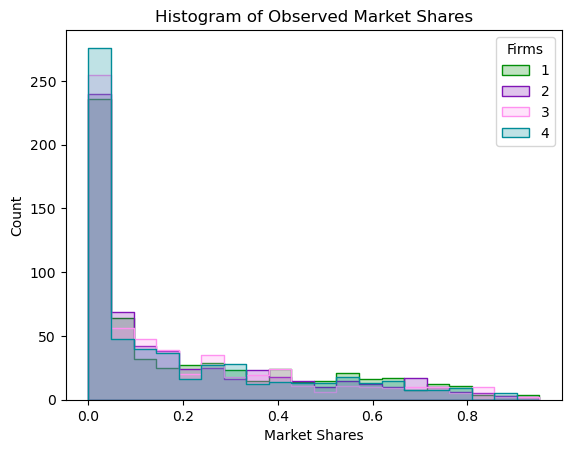

In [19]:
sns.histplot(data=obs_mkt_share, x='obs_market_share', hue='firm_ids', bins=20, element='step', palette = zhoskaya)
plt.title('Histogram of Observed Market Shares')
plt.xlabel('Market Shares')
plt.legend(title='Firms', labels=["1", "2", "3", "4"])
plt.show()

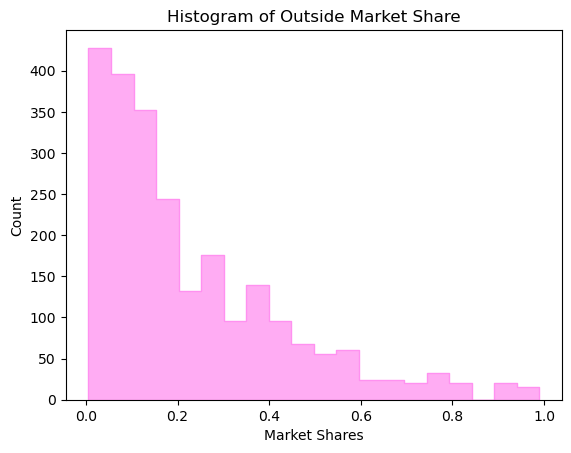

In [20]:
sns.histplot(data=obs_mkt_share, x='obs_outside_mkt_share', bins=20, element='step', color = '#ff91f0')
plt.title('Histogram of Outside Market Share')
plt.xlabel('Market Shares')
plt.show()

3 Estimate Some Mis-specified Models - OLS Estimation 

In [21]:
obs_mkt_share['log_delta'] = np.log(obs_mkt_share['obs_market_share']/obs_mkt_share['obs_outside_mkt_share'])
q3a_ols = sm.OLS(endog = obs_mkt_share['log_delta'], exog = obs_mkt_share[['prices', 'x', 'satellite', 'wired']]).fit()
print(q3a_ols.summary())

                            OLS Regression Results                            
Dep. Variable:              log_delta   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 5.519e+04
Date:                Fri, 21 Mar 2025   Prob (F-statistic):               0.00
Time:                        19:02:06   Log-Likelihood:                -3341.8
No. Observations:                2400   AIC:                             6692.
Df Residuals:                    2396   BIC:                             6715.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
prices        -1.9783      0.005   -405.624      0.0

3 Estimate Some Mis-specified Models - 2SLS IV Estimation

In [22]:
other_x = obs_mkt_share.pivot(index="market_ids", columns="firm_ids", values="x")

for i in range(3):
    obs_mkt_share[f"x_comp_{i}"] = obs_mkt_share.apply(lambda row: other_x.loc[row["market_ids"]].drop(row["firm_ids"]).values[i], axis=1)

obs_mkt_share

,market_ids,firm_ids,x,w,resid_d,resid_s,satellite,wired,prices,shares,obs_market_share,obs_outside_mkt_share,log_delta,x_comp_0,x_comp_1,x_comp_2
0,0,0,0.584659,0.059686,-0.655744,-1.197582,1,0,2.431042,0.165149,0.076036,0.180494,-0.864495,0.615863,0.008683,0.219364
1,0,1,0.615863,1.405901,0.308498,-1.051435,1,0,2.208473,0.115427,0.321111,0.180494,0.576091,0.584659,0.008683,0.219364
2,0,2,0.008683,0.964780,0.023973,0.261552,0,1,3.282374,0.004873,0.014411,0.180494,-2.527702,0.584659,0.615863,0.219364
3,0,3,0.219364,1.345774,0.227340,-0.437815,0,1,1.817825,0.517959,0.407948,0.180494,0.815442,0.584659,0.615863,0.008683
4,1,0,1.497799,0.465470,-0.876247,0.522240,1,0,1.810379,0.580827,0.373785,0.130379,1.053236,1.486218,0.294974,1.374500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,598,3,1.463330,2.092736,0.796357,-1.712362,0,1,2.410689,0.474103,0.660168,0.190876,1.240872,2.429626,0.144473,1.728181
2396,599,0,1.273187,2.126454,0.727938,-0.141237,1,0,2.031066,0.417114,0.460115,0.066364,1.936317,0.635075,1.577327,0.444817
2397,599,1,0.635075,0.463315,-0.076396,1.325731,1,0,4.644768,0.000730,0.000584,0.066364,-4.733532,1.273187,1.577327,0.444817
2398,599,2,1.577327,1.420527,0.421740,0.747195,0,1,2.007628,0.436439,0.455424,0.066364,1.926069,1.273187,0.635075,0.444817


In [23]:
q3b_ols = lm.IV2SLS(dependent = obs_mkt_share['log_delta'], 
                   exog = obs_mkt_share[['x', 'satellite', 'wired']], 
                   endog = obs_mkt_share['prices'], 
                   instruments = obs_mkt_share[['w', 'x_comp_0', 'x_comp_1', 'x_comp_2']]).fit()
print(q3b_ols.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:              log_delta   R-squared:                      0.9845
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9845
No. Observations:                2400   F-statistic:                 2.829e+04
Date:                Fri, Mar 21 2025   P-value (F-stat)                0.0000
Time:                        19:02:08   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
x              0.9188     0.0338     27.174     0.0000      0.8525      0.9851
satellite      3.7930     0.1740     21.798     0.00

4 Estimate the Correctly Specified Model - BLP Demand Alone

In [24]:
demand_alone = pyblp.Problem(
    product_formulations=(
    X1_formulation,
    X2_formulation,
    ),
    product_data=obs_mkt_share,
    integration=Integration,
    costs_type="log",
    add_exogenous=True,
)

result_demand = demand_alone.solve(
    sigma=np.eye(2) * 0.5,
)

Initializing the problem ...
Initialized the problem after 00:00:00.

Dimensions:
 T    N     F     I     K1    K2    MD 
---  ----  ---  -----  ----  ----  ----
600  2400   4   48600   4     2     3  

Formulations:
       Column Indices:             0          1        2      3   
-----------------------------  ---------  ---------  -----  ------
 X1: Linear Characteristics        x      satellite  wired  prices
X2: Nonlinear Characteristics  satellite    wired                 
Solving the problem ...

Nonlinear Coefficient Initial Values:
 Sigma:      satellite        wired    
---------  -------------  -------------
satellite  +5.000000E-01               
  wired    +0.000000E+00  +5.000000E-01

Nonlinear Coefficient Lower Bounds:
 Sigma:      satellite        wired    
---------  -------------  -------------
satellite  +0.000000E+00               
  wired    +0.000000E+00  +0.000000E+00

Nonlinear Coefficient Upper Bounds:
 Sigma:      satellite        wired    
---------  -------

The model may be under-identified. The total number of unfixed parameters is 6, which is more than the total number of moments, 3. Consider checking whether instruments were properly specified when initializing the problem, and whether parameters were properly configured when solving the problem.



At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.

GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped    Objective      Objective      Projected                                
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Shares       Value       Improvement   Gradient Norm             Theta            

In [25]:
demand_supply = pyblp.Problem(
    product_formulations=(
    X1_formulation,
    X2_formulation,
    X3_formulation,
    ),
    product_data=obs_mkt_share,
    integration=Integration,
    costs_type="log",
    add_exogenous=True,
)

result_demand_supply = demand_supply.solve(
    sigma=np.eye(2) * 0.5,
    beta=[None, None, None, -1],
)

Initializing the problem ...
Initialized the problem after 00:00:00.

Dimensions:
 T    N     F     I     K1    K2    K3    MD    MS 
---  ----  ---  -----  ----  ----  ----  ----  ----
600  2400   4   48600   4     2     2     3     2  

Formulations:
       Column Indices:             0          1        2      3   
-----------------------------  ---------  ---------  -----  ------
 X1: Linear Characteristics        x      satellite  wired  prices
X2: Nonlinear Characteristics  satellite    wired                 
X3: Log Cost Characteristics       1          w                   
Solving the problem ...

Nonlinear Coefficient Initial Values:
 Sigma:      satellite        wired    
---------  -------------  -------------
satellite  +5.000000E-01               
  wired    +0.000000E+00  +5.000000E-01

Beta Initial Values:
      x          satellite        wired         prices    
-------------  -------------  -------------  -------------
     NAN            NAN            NAN       -1.0

The model may be under-identified. The total number of unfixed parameters is 8, which is more than the total number of moments, 5. Consider checking whether instruments were properly specified when initializing the problem, and whether parameters were properly configured when solving the problem.



At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
Encountered nonpositive marginal costs in a log-linear specification. This problem can sometimes be mitigated by bounding costs from below, choosing more reasonable initial parameter values, setting more conservative parameter bounds, or using a linear costs specification.
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.
Reverted problematic marginal costs.

In [26]:
demand_supply_iv = result_demand_supply.compute_optimal_instruments().to_problem()

result_demand_supply_iv = demand_supply_iv.solve(
    sigma=np.eye(2) * 0.5,
    beta=[None, None, None, -1],
)

Computing optimal instruments for theta ...
Computed optimal instruments after 00:00:02.

Optimal Instrument Results Summary:
Computation  Error Term  Fixed Point  Contraction
   Time        Draws     Iterations   Evaluations
-----------  ----------  -----------  -----------
 00:00:02        1          5964         5964    
Re-creating the problem ...
Re-created the problem after 00:00:00.

Dimensions:
 T    N     F     I     K1    K2    K3    MD    MS 
---  ----  ---  -----  ----  ----  ----  ----  ----
600  2400   4   48600   4     2     2     7     8  

Formulations:
       Column Indices:             0          1        2      3   
-----------------------------  ---------  ---------  -----  ------
 X1: Linear Characteristics        x      satellite  wired  prices
X2: Nonlinear Characteristics  satellite    wired                 
X3: Log Cost Characteristics       1          w                   
Solving the problem ...

Nonlinear Coefficient Initial Values:
 Sigma:      satellite   

Detected collinearity issues with [1] and at least one other column in ZS. To disable collinearity checks, set options.collinear_atol = options.collinear_rtol = 0.
Detected that the 2SLS weighting matrix is nearly singular with condition number +2.789039E+18. To disable singularity checks, set options.singular_tol = numpy.inf.



At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
Encountered nonpositive marginal costs in a log-linear specification. This problem can sometimes be mitigated by bounding costs from below, choosing more reasonable initial parameter values, setting more conservative parameter bounds, or using a linear costs specification.
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.
Reverted problematic marginal costs.


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.

 1     00:00:03         2             9          9279         28346        0     -1.694845E+03                 +4.889573E+03  +7.467710E-01, +5.548667E-01, -2.282048E+00

At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, th


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.

 1     00:00:04         3            19          12599        38298        0     -1.694845E+03                 +3.111022E+03  +7.467710E-01, +5.548667E-01, -2.282048E+00

At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, th


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.

 1     00:00:04         4            29          12584        38266        0     -3.901884E+03                 +3.111022E+03  +7.467710E-01, +5.548667E-01, -2.282048E+00

At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, th


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.

 1     00:00:03         5            39          7612         23354        0     +2.290745E+03                 +3.111022E+03  +7.467710E-01, +5.548667E-01, -2.282048E+00

At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, th


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.

 1     00:00:03         5            49          10921        33271        0     -3.901884E+03                 +4.889482E+03  +7.467710E-01, +5.548667E-01, -2.282048E+00

At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, th


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.

 1     00:00:04         5            58          12585        38263        0     -5.680435E+03                 +3.111022E+03  +7.467710E-01, +5.548667E-01, -2.282048E+00

At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, th

Detected that the estimated covariance matrix of aggregate GMM moments is nearly singular with condition number +6.526092E+16. To disable singularity checks, set options.singular_tol = numpy.inf.



The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.

Computed results after 00:00:26.

Problem Results Summary:
GMM     Objective      Projected    Reduced Hessian  Reduced Hessian  Clipped  Weighting Matrix
Step      Value      Gradient Norm  Min Eigenvalue   Max Eigenvalue   Shares   Condition Number
----  -------------  -------------  ---------------  ---------------  -------  ----------------
 1    -5.680435E+03  +3.111022E+03   -6.210888E+10    +5.735350E+10      0      +1.039033E+18  

Starting optimization ...


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a prob


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
Encountered nonpositive marginal costs in a log-linear specification. This problem can sometimes be mitigated by bounding costs from below, choosing more reasonable initial parameter values, setting more conservative parameter bounds, or using a linear costs specification.
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.
Reverted problematic marginal costs.


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.
Encountered nonpositive marginal costs in a log-linear specification. This problem can sometimes be mitigated by bounding costs from below, choosing more reasonable initial parameter values, setting more conservative parameter bounds, or using a linear costs specification.
Reverted problematic marginal costs.


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
Encountered nonpositive marginal costs in a log-linear specification. This problem can sometimes be mitigated by bounding costs from below, choosing more reasonable initial parameter values, setting more conservative parameter bounds, or using a linear costs specification.
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.
Reverted problematic marginal costs.


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
Encountered nonpositive marginal costs in a log-linear specification. This problem can sometimes be mitigated by bounding costs from below, choosing more reasonable initial parameter values, setting more conservative parameter bounds, or using a linear costs specification.
The fixed point computation of delta failed to converge. This problem can sometimes be mitigated by increasing the maximum number of fixed point iterations, increasing the fixed point tolerance, choosing more reasonable initial parameter values, setting more conservative parameter or share bounds, or using different iteration or optimization configurations.
Reverted problematic marginal costs.

Detected that the estimated covariance matrix of aggregate GMM moments is nearly singular with condition number +2.227919E+16. To disable singularity checks, set options.singular_tol = numpy.inf.
Detected that the estimated covariance matrix of aggregate GMM moments is nearly singular with condition number +3.199804E+16. To disable singularity checks, set options.singular_tol = numpy.inf.


In [27]:
iv_elasticity = result_demand_supply_iv.compute_elasticities()

iv_avg_elasticity = np.mean(iv_elasticity, axis=0)

iv_avg_elasticity

Computing elasticities with respect to prices ...
Finished after 00:00:00.



array([-1.35073837, -1.45145918, -1.21875517, -1.08400747])

In [28]:
avg_s = obs_mkt_share.groupby('firm_ids')['obs_market_share'].mean()

elasticity = [-x * (1 - x) * (4 + 4) for x in avg_s]

elasticity

[-1.1832197864772278,
 -1.1863861373425153,
 -1.2491454984517054,
 -1.3446458168875814]

In [29]:
obs_mkt_share.to_csv("PS3.csv", index=False)